# Import

In [45]:
# General data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Utilities
import json
import os
import random
import csv
import joblib
from collections import Counter

# Signal processing (for resampling segments)
from scipy.signal import resample

# Deep learning (used for future autoencoder or sequence models)
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import LSTM, GRU, Input, RepeatVector, TimeDistributed, Dense, Dropout

# Preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Cloud storage access
from google.cloud import storage

# Load and Prepare Train Data

In [2]:
# CSV containing filepaths and labeled time segments (start/end indices)
results_csv = "labeled_s.csv"
df_csv = pd.read_csv(results_csv)

# Get all unique filepaths used in the dataset
filepaths = set([val["filepath"] for index, val in df_csv.iterrows() if val["label"] == "White"])
print("Number of white segments : ", len(df_csv[df_csv["label"]=="White"]))

# Load each file, remove unstable regions, and keep only alpha/beta angles
X_tot = []
for file in filepaths : 
    df = pd.read_parquet(file)
    df = df.iloc[125:-7500]
    X_file = df[["alpha_angle", "beta_angle"]].to_numpy()
    X_tot.append(dict(filepath = file, data = X_file))

data_train = []

# Extract time windows from the selected labeled segments
for index, val in df_csv.iterrows() :
    file = val["filepath"]
    start = val["start_index"]

    if val["label"] == "White" :
        X = [X["data"] for X in X_tot if X["filepath"] == file][0]
        X = X[val["start_index"]:val["end_index"]]
        data_train.append(np.array(X[:22400]))

XTrain = np.concatenate(data_train, axis=0)

# Normalize using precomputed scaler
scaler = joblib.load("Models/scaler_ab.joblib")
XTrain = scaler.transform(XTrain)

# Reshape
XTrain = XTrain.astype(np.float32).reshape(-1, 128, 2)

XTrain.shape

Number of white segments :  183


(32025, 128, 2)

In [2]:
# Load list of all usable files (generated earlier)
if os.path.exists("all_files.json") :
    with open("all_files.json", 'r') as f :
        files = json.load(f)

# Keep only 'normal' files (non-scenario data)
normal_file = [file for file in files[1] if not "scenario" in file]
index_normal_file = list(enumerate(normal_file))
random.shuffle(index_normal_file) # Shuffle for randomness in selection

In [3]:
XTrain, index_train, j = [], [], 0

# Load and preprocess 200 random files (no scenario)
for i, filePath in index_normal_file[:200] :
    j += 1
    if j%20 == 0 : print(j)

    df = pd.read_parquet(filePath, engine="fastparquet")
    df = df.iloc[1500:-7500] # Remove noisy start and end regions
    n = (len(df)//128)*128
    df = df.iloc[:n]
    X = df[["alpha_angle","beta_angle"]].to_numpy()
    XTrain.append(X.astype(np.float32))
    index_train.append(i)

# Concatenate all windows into a single array
XTrain = np.concatenate(XTrain, axis=0)

# Normalize using precomputed scaler
scaler = joblib.load("Models/scaler_ab.joblib")
XTrain = scaler.transform(XTrain)

# Reshape for LSTM input
XTrain = XTrain.astype(np.float32).reshape(-1, 128, 2)
np.info(XTrain)

20
40
60
80
100
120
140
160
180
200
class:  ndarray
shape:  (381078, 128, 2)
strides:  (512, 4, 195111936)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x7fb804bda010
byteorder:  little
byteswap:  False
type: float32


# Models

In [3]:
# Define Autoencoder Model
class Autoencoder(Model):
    def __init__(self, input_shape):
        super().__init__()
        
        RNNLayer=tf.keras.layers.LSTM # Can choose LSTM or GRU
        
        # Define encoder block
        self.encoder = tf.keras.Sequential([
            RNNLayer(128, return_sequences=True, activation='tanh'),
            RNNLayer(64, return_sequences=True, activation='tanh'),
            RNNLayer(32, return_sequences=True, activation='tanh'),
            RNNLayer(16, return_sequences=False, activation='tanh') # Bottleneck
        ])
        
        # Define decoder block (mirrored structure)
        self.decoder = tf.keras.Sequential([
            RepeatVector(input_shape[0]),
            RNNLayer(32, return_sequences=True, activation='tanh'),
            RNNLayer(64, return_sequences=True, activation='tanh'),
            RNNLayer(128, return_sequences=True, activation='tanh'),
            TimeDistributed(Dense(input_shape[1])) # Reconstruct each timestep
        ])

    def call(self, inputs):
        z = self.encoder(inputs) # Encode to latent space
        x_recon = self.decoder(z) # Reconstruct from latent
        return x_recon

In [4]:
# Dataset Creation Helper Function
def create_dataset(data, batch_size=16, shuffle=True):
    with tf.device('/CPU:0'):
        dataset = tf.data.Dataset.from_tensor_slices((data, data)) # Autoencoder: input = target

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [8]:
# Training Setup
checkpoint_dir = "checkpointsLSTM_normal" # Directory for weight checkpoints
loss_path = "loss_LSTM_normal.json" # Path to save training history
X = XTrain

# Split data into train/validation sets (80/20)
split_index = int(len(X) * 0.8)
train_data = X[:split_index]
val_data = X[split_index:]

# Convert to tf.data.Datasets
train_dataset = create_dataset(train_data, batch_size=16, shuffle=True)
val_dataset   = create_dataset(val_data, batch_size=16, shuffle=False)

# Build model instance
model = Autoencoder(input_shape=(128, 2))
model.compile(optimizer='adam', loss='mse')

# Ensure checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Load loss history if previously saved
if os.path.exists(loss_path):
    with open(loss_path, 'r') as f:
        loss_history = json.load(f)
else:
    loss_history = {"train_loss": [], "val_loss": []}

# Find latest checkpoint to resume training if interrupted
latest_epoch = 0
weights_path = None
for i in range(1, 201):
    path = os.path.join(checkpoint_dir, f"weights_epoch_{i:03d}.h5")
    if os.path.exists(path):
        latest_epoch = i
        weights_path = path

# Load weights if found
if weights_path:
    print(f"{weights_path}")
    model(tf.zeros((1, 128, 2)))
    model.load_weights(weights_path)

# Training Loop
start_epoch = latest_epoch + 1
end_epoch = 200

for epoch in range(start_epoch, end_epoch + 1):
    print(f"\n--- Epoch {epoch} ---")

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=1,
        verbose=1
    )

    # Save loss history after each epoch
    train_loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    loss_history["train_loss"].append(train_loss)
    loss_history["val_loss"].append(val_loss)

    with open(loss_path, "w") as f:
        json.dump(loss_history, f, indent=4)
        
    # Save model weights after each epoch
    weights_save_path = os.path.join(checkpoint_dir, f"weights_epoch_{epoch:03d}.h5")
    model.save_weights(weights_save_path)
    print(f"Store {weights_save_path}")

checkpointsLSTM_normal/weights_epoch_170.h5

--- Epoch 171 ---
1602/1602 [==============================] - 61s 32ms/step - loss: 0.0034 - val_loss: 0.0052
Store checkpointsLSTM_normal/weights_epoch_171.h5

--- Epoch 172 ---
1602/1602 [==============================] - 49s 30ms/step - loss: 0.0035 - val_loss: 0.0050
Store checkpointsLSTM_normal/weights_epoch_172.h5

--- Epoch 173 ---
1602/1602 [==============================] - 49s 31ms/step - loss: 0.0036 - val_loss: 0.0052
Store checkpointsLSTM_normal/weights_epoch_173.h5

--- Epoch 174 ---
1602/1602 [==============================] - 49s 31ms/step - loss: 0.0034 - val_loss: 0.0050
Store checkpointsLSTM_normal/weights_epoch_174.h5

--- Epoch 175 ---
1602/1602 [==============================] - 49s 31ms/step - loss: 0.0033 - val_loss: 0.0052
Store checkpointsLSTM_normal/weights_epoch_175.h5

--- Epoch 176 ---
1602/1602 [==============================] - 49s 31ms/step - loss: 0.0035 - val_loss: 0.0054
Store checkpointsLSTM_normal/weigh

## Train / Val Loss

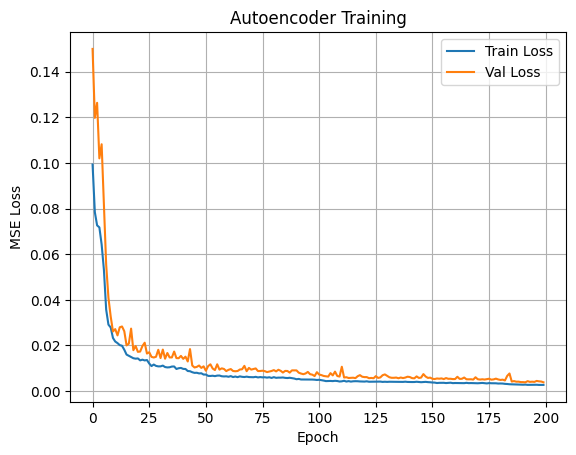

In [9]:
#Plot Training and Validation Loss
loss_name = "loss_LSTM_normal.json"
if os.path.exists(loss_name) :
    with open(loss_name, 'r') as f :
        loss_history = json.load(f)

plt.plot(loss_history["train_loss"], label="Train Loss")
plt.plot(loss_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training")
plt.legend()
plt.grid(True)
plt.show()

## Save model

In [10]:
# Save a new model with the last checkpoint weight
checkpoint_dir = "checkpointsLSTM_normal"
weights_path = os.path.join(checkpoint_dir, "weights_epoch_199.h5")

if os.path.exists(weights_path):
    model = Autoencoder(input_shape=(128, 2))
    model(tf.zeros((1, 128, 2)))
    model.load_weights(weights_path)
else:
    print("Error")

model.save("LSTM_alpha_beta_128_64_32_16_white", save_format="tf")

INFO:tensorflow:Assets written to: LSTM_alpha_beta_128_64_32_16_white/assets


INFO:tensorflow:Assets written to: LSTM_alpha_beta_128_64_32_16_white/assets


In [12]:
import shutil

# Remove old checkpoint directory
checkpoint_dir = "checkpointsLSTM_normal"

if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

## Visualisation

In [77]:
# Load GRU and LSTM model
model_GRU = tf.keras.models.load_model("Models/GRU_alpha_beta_128_64_32_16")
model_GRU.compile(optimizer='adam', loss='mse')

model_LSTM = tf.keras.models.load_model("Models/LSTM_alpha_beta_128_64_32_16")
model_LSTM.compile(optimizer='adam', loss='mse')

74/74 [==============================] - 1s 12ms/step


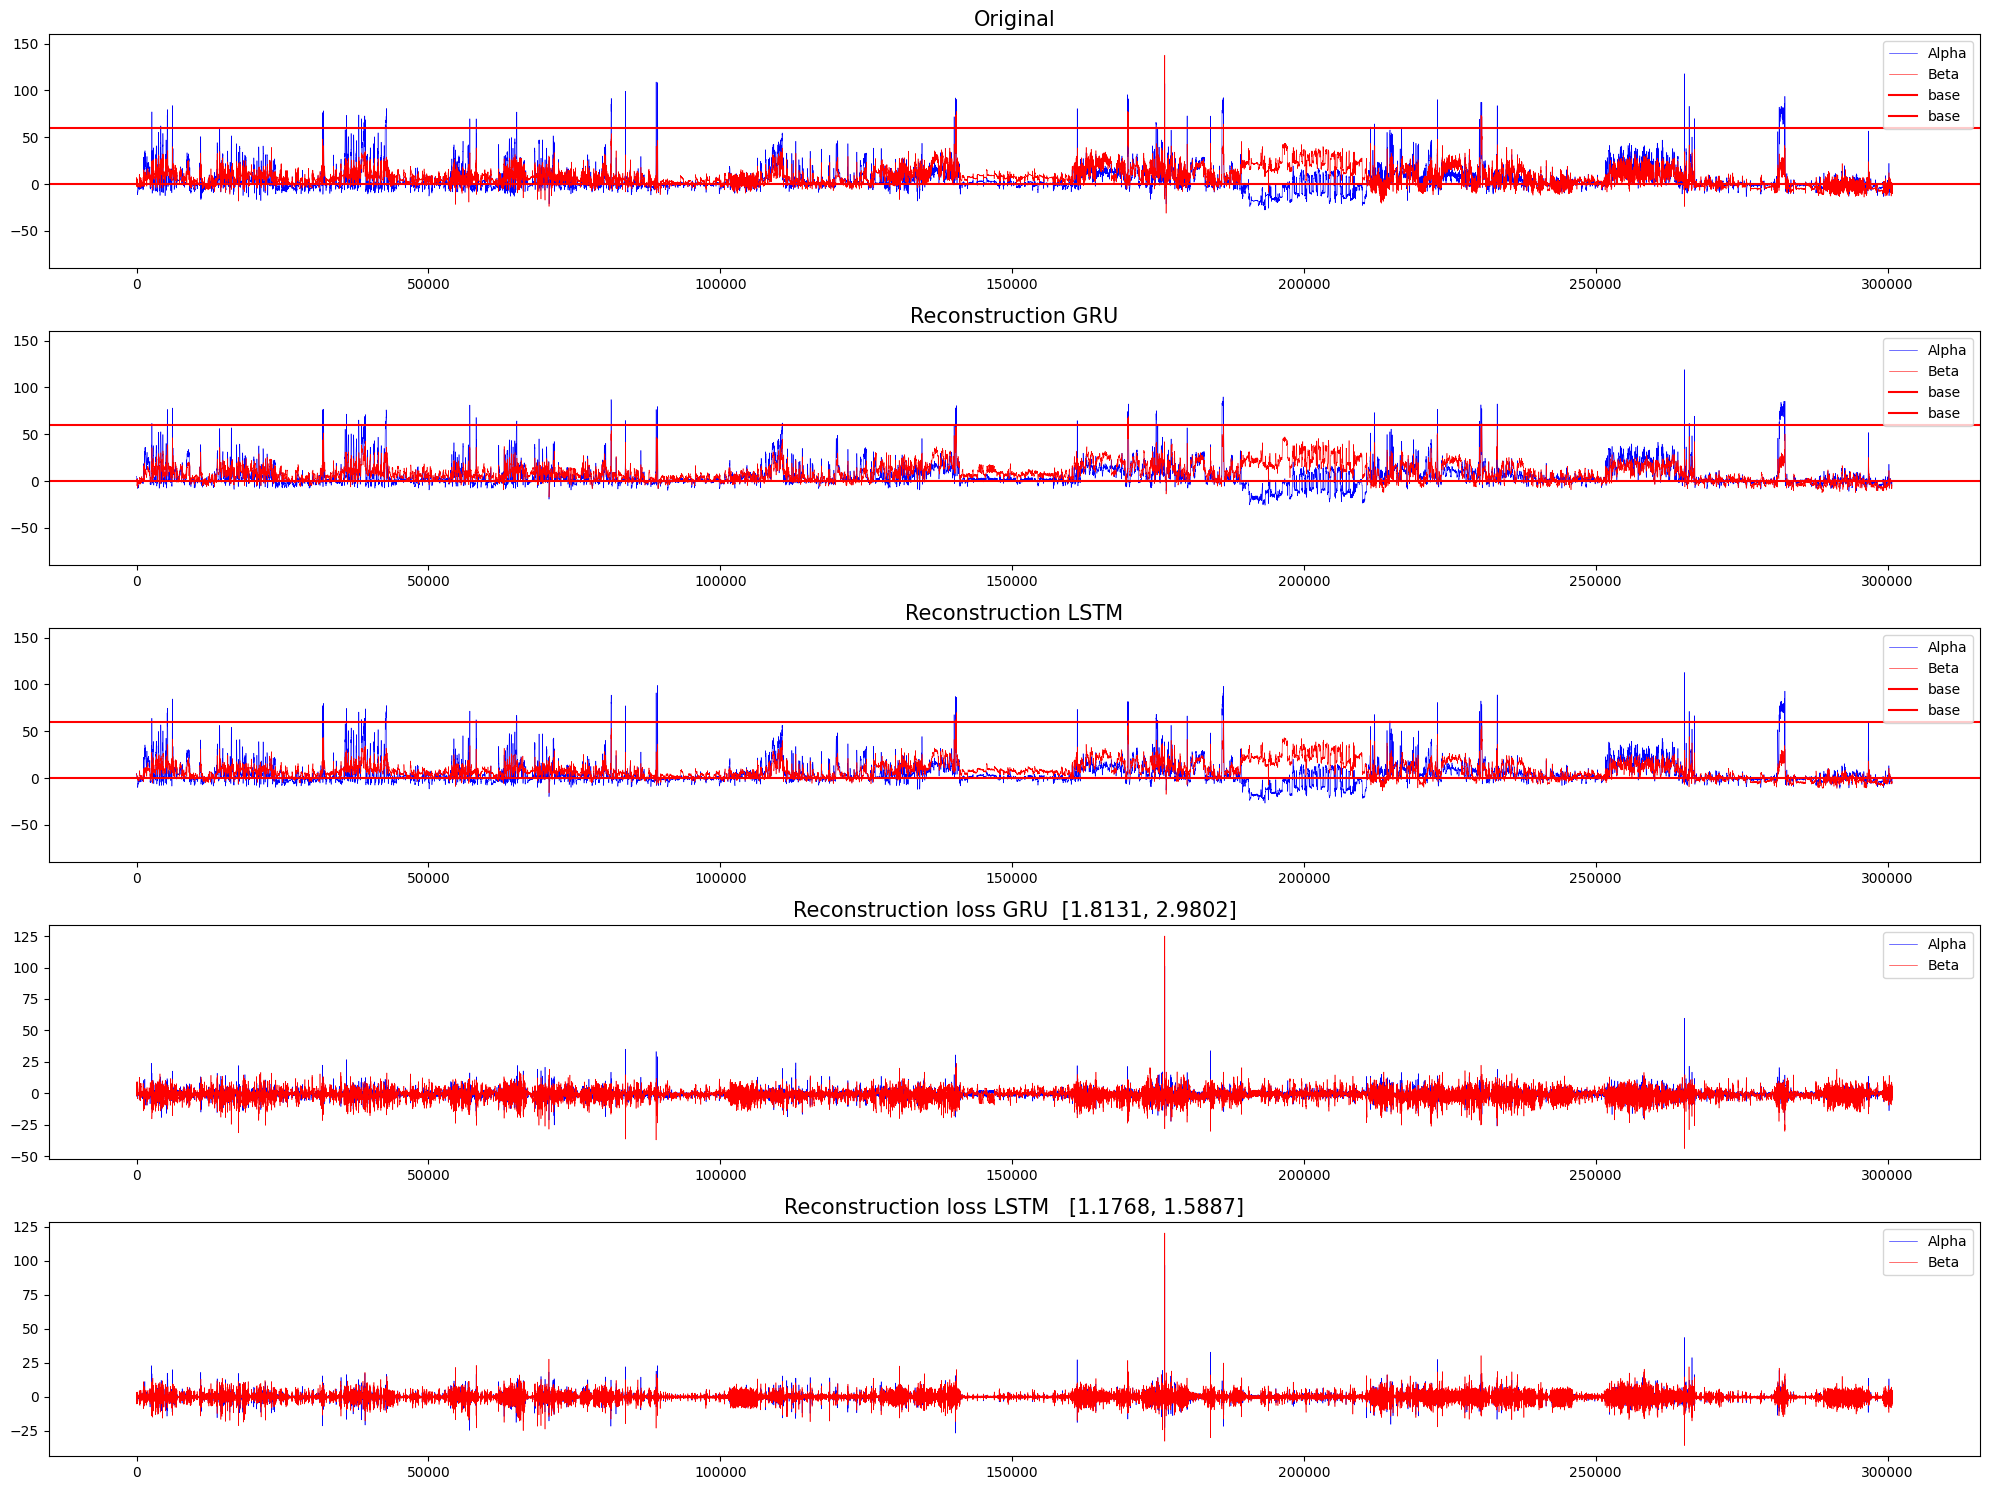

In [105]:
file = normal_file[8]

df = pd.read_parquet(file)
df = df.iloc[1500:-7500]
df = df.iloc[:(len(df)//128)*128]

X = df[["alpha_angle", "beta_angle"]].to_numpy()

scaler = joblib.load("Models/scaler_ab.joblib")
X_file = scaler.transform(X)
X_file = X_file.astype(np.float32).reshape(-1, 128, 2)
    
recons_gru = model_GRU.predict(X_file)
recons_gru = recons_gru.reshape(-1, 2).astype(np.float64)
recons_gru = scaler.inverse_transform(recons_gru)
recons_loss_gru = X - recons_gru
med_loss_gru = [round(np.mean(abs(recons_loss_gru[:,0])),4), round(np.mean(abs(recons_loss_gru[:,1])),4)]

recons_lstm = model_LSTM.predict(X_file)
recons_lstm = recons_lstm.reshape(-1, 2).astype(np.float64)
recons_lstm = scaler.inverse_transform(recons_lstm)
recons_loss_lstm = X - recons_lstm
med_loss_lstm = [round(np.mean(abs(recons_loss_lstm[:,0])),4), round(np.mean(abs(recons_loss_lstm[:,1])),4)]

plt.figure(figsize=(20, 15))

plt.subplot(5, 1, 1)
plt.plot(X[:, 0], label='Alpha', color='blue', linewidth=0.4)
plt.plot(X[:, 1], label='Beta', color='red', linewidth=0.4)
plt.axhline(y=0.0, color='r', linestyle='-', label='base')
plt.axhline(y=60.0, color='r', linestyle='-', label='base')
plt.ylim(-90,160)
plt.title("Original", fontsize = 15)
plt.legend()
    
plt.subplot(5, 1, 2)
plt.plot(recons_gru[:, 0], label='Alpha', color='blue', linewidth=0.4)
plt.plot(recons_gru[:, 1], label='Beta', color='red', linewidth=0.4)
plt.axhline(y=0.0, color='r', linestyle='-', label='base')
plt.axhline(y=60.0, color='r', linestyle='-', label='base')
plt.ylim(-90,160)
plt.title("Reconstruction GRU", fontsize = 15)
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(recons_lstm[:, 0], label='Alpha', color='blue', linewidth=0.4)
plt.plot(recons_lstm[:, 1], label='Beta', color='red', linewidth=0.4)
plt.axhline(y=0.0, color='r', linestyle='-', label='base')
plt.axhline(y=60.0, color='r', linestyle='-', label='base')
plt.ylim(-90,160)
plt.title("Reconstruction LSTM", fontsize = 15)
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(recons_loss_gru[:, 0], label='Alpha', color='blue', linewidth=0.4)
plt.plot(recons_loss_gru[:, 1], label='Beta', color='red', linewidth=0.4)
plt.title("Reconstruction loss GRU  "+str(med_loss_gru), fontsize = 15)
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(recons_loss_lstm[:, 0], label='Alpha', color='blue', linewidth=0.4)
plt.plot(recons_loss_lstm[:, 1], label='Beta', color='red', linewidth=0.4)
plt.title("Reconstruction loss LSTM   "+str(med_loss_lstm), fontsize = 15)
plt.legend()
plt.tight_layout()
   
plt.show()

79/79 [==============================] - 1s 12ms/step


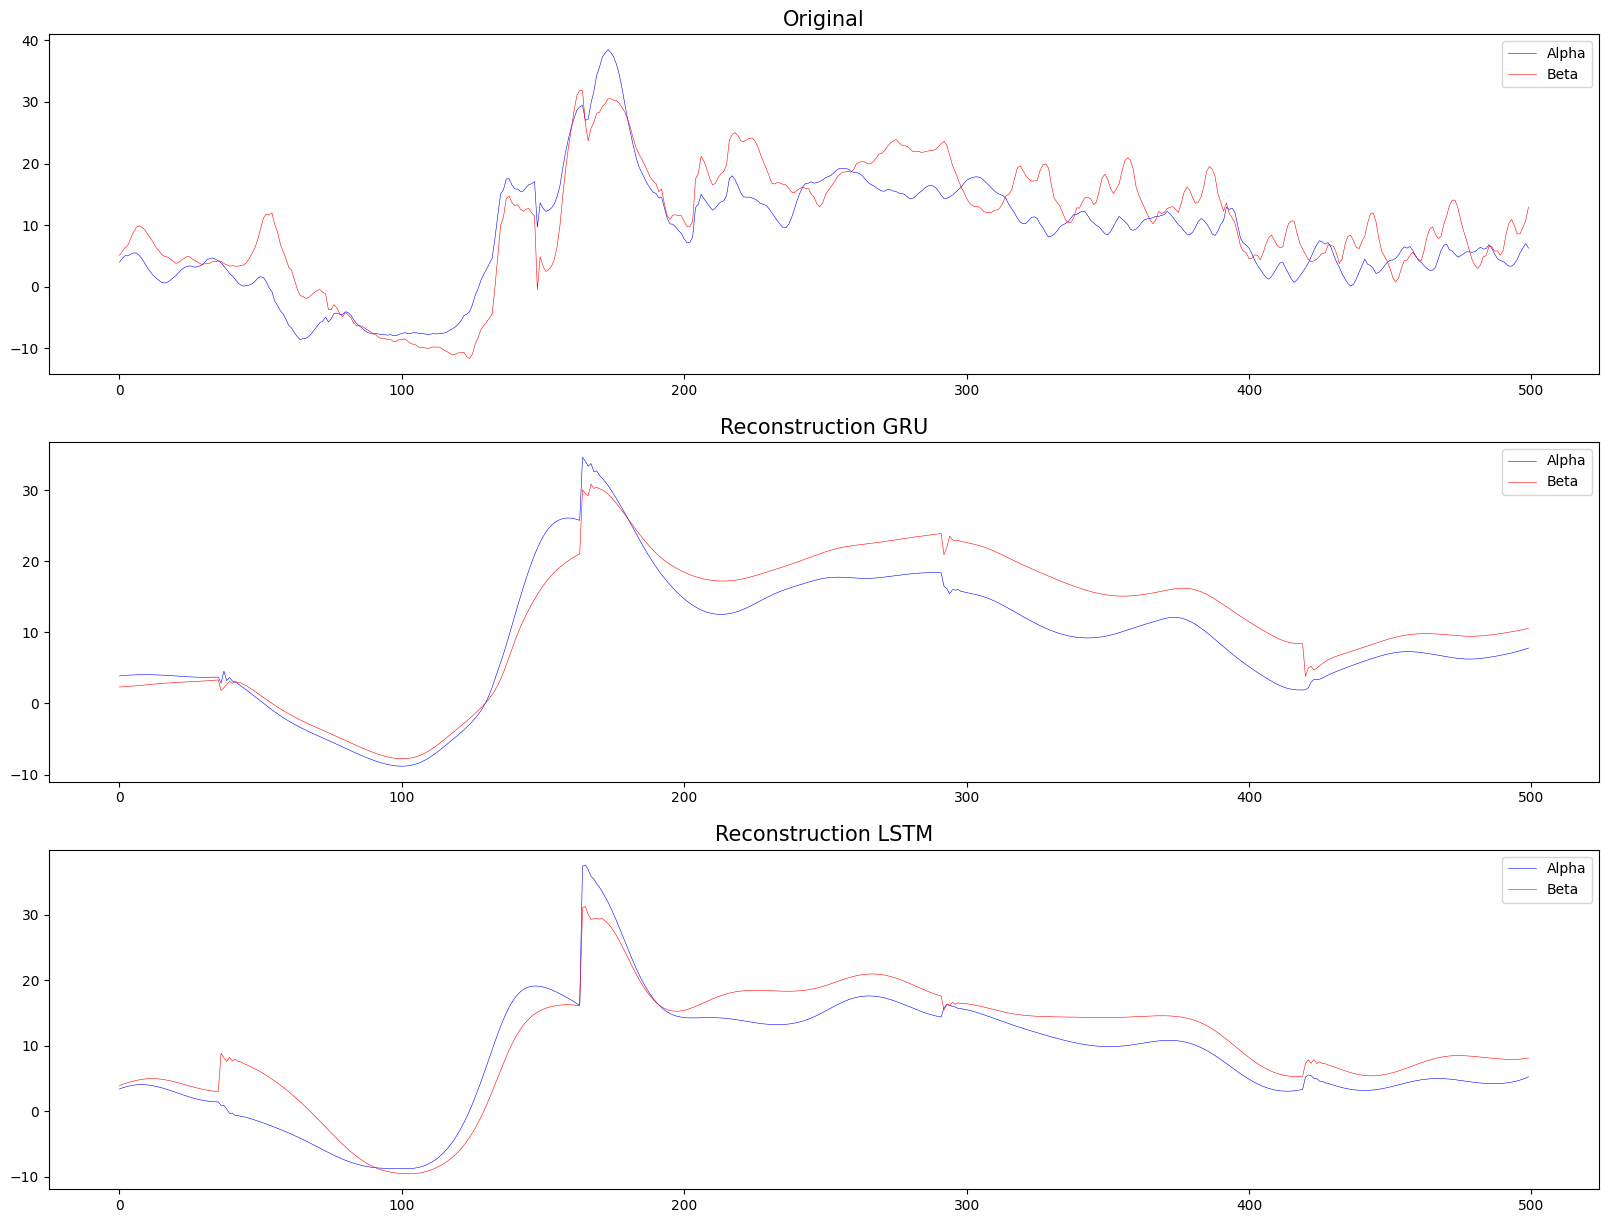

In [106]:
file = normal_file[5]
a,b = 1500,2000


df = pd.read_parquet(file)
df = df.iloc[1500:-7500]
df = df.iloc[:(len(df)//128)*128]

X = df[["alpha_angle", "beta_angle"]].to_numpy()   # ["neck_angle","belt_angle"]

scaler = joblib.load("Models/scaler_ab.joblib")
X_file = scaler.transform(X)
X_file = X_file.astype(np.float32).reshape(-1, 128, 2)
    
recons_gru = model_GRU.predict(X_file)
recons_gru = recons_gru.reshape(-1, 2).astype(np.float64)
recons_gru = scaler.inverse_transform(recons_gru)

recons_lstm = model_LSTM.predict(X_file)
recons_lstm = recons_lstm.reshape(-1, 2).astype(np.float64)
recons_lstm = scaler.inverse_transform(recons_lstm)

plt.figure(figsize=(20, 15))

plt.subplot(3, 1, 1)
plt.plot(X[:, 0][a:b], label='Alpha', color='blue', linewidth=0.4)
plt.plot(X[:, 1][a:b], label='Beta', color='red', linewidth=0.4)
plt.title("Original", fontsize = 15)
plt.legend()
    
plt.subplot(3, 1, 2)
plt.plot(recons_gru[:, 0][a:b], label='Alpha', color='blue', linewidth=0.4)
plt.plot(recons_gru[:, 1][a:b], label='Beta', color='red', linewidth=0.4)
plt.title("Reconstruction GRU", fontsize = 15)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(recons_lstm[:, 0][a:b], label='Alpha', color='blue', linewidth=0.4)
plt.plot(recons_lstm[:, 1][a:b], label='Beta', color='red', linewidth=0.4)
plt.title("Reconstruction LSTM", fontsize = 15)
plt.legend()

   
plt.show()

# Test Data

In [46]:
# CSV containing filepaths and labeled time segments (start/end indices)
results_csv = "labeled_s2.csv"
df_csv = pd.read_csv(results_csv)

# Get all unique filepaths used in the dataset
filepaths = set([val["filepath"] for index, val in df_csv.iterrows()])

# Load each file, remove unstable regions, and keep only alpha/beta angles
X_tot = []
for file in filepaths : 
    df = pd.read_parquet(file)
    df = df.iloc[125:-7500]
    X_file = df[["alpha_angle", "beta_angle"]].to_numpy()
    X_tot.append(dict(filepath = file, data = X_file))

# Separate rows by label type for reference
black = df_csv[df_csv["label"] == "Black"]
grey = df_csv[df_csv["label"] == "Grey"]
white = df_csv[df_csv["label"] == "White"]

data_train, index_train, label_train = [], [], []
nbw, nbb, nbg = 0, 0, 0

# Extract time windows from the selected labeled segments
for index, val in df_csv.iterrows():
    file = val["filepath"]
    start = val["start_index"]

    if val["label"] == "White" :
        nbw += 1
        label = 0
    elif val["label"] == "Black" :
        nbb += 1
        label = 1
    else:
        continue # Skip "exclude" or "grey" segments

    X = [X["data"] for X in X_tot if X["filepath"] == file][0]
    X = X[val["start_index"]:val["end_index"]]
    label_train.append(label)
    index_train.append(index)
    data_train.append(np.array(X[:22400]))

# Reshape
X_all = np.array(data_train).astype(np.float32).reshape(len(data_train), 175, 128, 2)
Y_all = np.array(label_train)

print(len(black), len(grey), len(white))
X_all.shape, Y_all.shape

500 130 500


((1000, 175, 128, 2), (1000,))

In [47]:
# Load LSTM and GRU models 
ae_gru = tf.keras.models.load_model("Models/GRU_alpha_beta_128_64_32_16")
ae_lstm = tf.keras.models.load_model("Models/LSTM_alpha_beta_128_64_32_16")
ae_lstm_w = tf.keras.models.load_model("Models/LSTM_alpha_beta_128_64_32_16_white")
ae_gru.compile(optimizer='adam', loss='mse')
ae_lstm.compile(optimizer='adam', loss='mse')
ae_lstm_w.compile(optimizer='adam', loss='mse')


# Extract the statistical parameters of the reconstruction loss for each segment
def reconstruction_loss(ae) :
    liste = []
    for X in X_all :
        reconstruction = ae.predict(X,verbose=0)
        loss = X - reconstruction
        loss = np.concatenate(loss)
        min_a, min_b = np.min(loss[:,0]), np.min(loss[:,1])
        med_a, med_b = np.median(loss[:,0]), np.median(loss[:,1])
        mean_a, mean_b = np.mean(loss[:,0]), np.mean(loss[:,1])
        max_a, max_b = np.max(loss[:,0]), np.max(loss[:,1])
        std_a, std_b = np.std(loss[:,0]), np.std(loss[:,1])
        liste.append([min_a, min_b, med_a, med_b, mean_a, mean_b, max_a, max_b, std_a, std_b])
    return liste

# List with the statictical parameters for each model (10,1)
loss_gru = reconstruction_loss(ae_gru)
loss_lstm = reconstruction_loss(ae_lstm)
loss_lstm_w = reconstruction_loss(ae_lstm_w)

In [65]:
# Train-test split and RandomForest Classifier training
X_train, X_test, Y_train, Y_test = train_test_split(loss_lstm, Y_all, test_size=0.6, random_state=None)

model = RandomForestClassifier(n_estimators=200, random_state=None)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# Evaluate model
print("Accuracy:", round(accuracy_score(Y_test, Y_pred), 4))
print("\nClassification report:")
print(classification_report(Y_test, Y_pred, target_names=["White", "Black"], zero_division=0))
print("Confusion matrix:")
print(confusion_matrix(Y_test, Y_pred))

Accuracy: 0.9933

Classification report:
              precision    recall  f1-score   support

       White       0.99      1.00      0.99       291
       Black       1.00      0.99      0.99       309

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

Confusion matrix:
[[290   1]
 [  3 306]]


## Visualisation Random Forest FP NP

In [31]:
# Visualize false positives and false negatives
csv_index = [[],[]]
acc = []

for nb in range(200) :
    X, Y = np.array(loss_gru), np.array(Y_all)

    indices = np.arange(len(Y))
    idx_train, idx_test, Y_train, Y_test = train_test_split(indices, Y, test_size=0.7, random_state=None)

    X_train = X[idx_train]
    X_test  = X[idx_test]

    clf = RandomForestClassifier(n_estimators=200, random_state=None)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    #print("Accuracy:", round(accuracy_score(Y_test, Y_pred), 4))
    #print("Confusion matrix:\n", confusion_matrix(Y_test, Y_pred))
    #print("Classification report:\n", classification_report(Y_test, Y_pred))

    false_positives = np.where((Y_test == 0) & (Y_pred == 1))[0]
    false_negatives = np.where((Y_test == 1) & (Y_pred == 0))[0]

    fp_indices = idx_test[false_positives]
    fn_indices = idx_test[false_negatives]

    csv_index[0].extend([index_train[i] for i in fp_indices])
    csv_index[1].extend([index_train[i] for i in fn_indices])
    
    acc.append(round(accuracy_score(Y_test, Y_pred), 4))
    
    #print("FP :", fp_indices)
    #print("FN :", fn_indices,"\n")

    #print("Index csv FP :", [index_train[i] for i in fp_indices])
    #print("Index csv FN :", [index_train[i] for i in fn_indices])

In [32]:
Counter(csv_index[1]).most_common(15)

(0.9844545000000001,
 0.9878,
 0.009558042673581237,
 [(119, 80),
  (78, 54),
  (364, 38),
  (317, 17),
  (515, 9),
  (261, 7),
  (82, 5),
  (363, 2)],
 (),
 [(108, 147),
  (88, 133),
  (51, 59),
  (160, 55),
  (115, 55),
  (104, 19),
  (125, 14),
  (2, 11),
  (124, 10),
  (5, 10),
  (4, 8),
  (1, 7),
  (3, 7),
  (367, 7),
  (138, 5)])

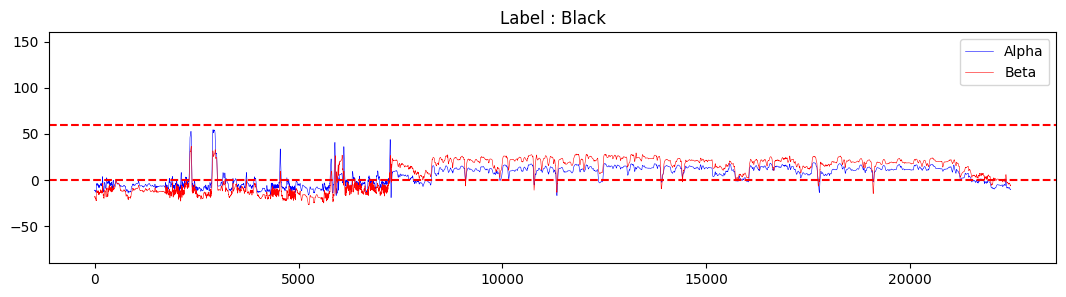

In [36]:
i = 88 # Same index in Analyze

df = pd.read_parquet(df_csv.loc[i, "filepath"])
df = df.iloc[125:].iloc[:-7500]
X = df[["alpha_angle", "beta_angle"]].to_numpy()
X = X[df_csv.loc[i, "start_index"]:df_csv.loc[i, "end_index"]]

plt.figure(figsize=(13, 3))
plt.plot(X[:, 0], label='Alpha', color='blue', linewidth=0.4)
plt.plot(X[:, 1], label='Beta', color='red', linewidth=0.4)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axhline(y=60.0, color='r', linestyle='--')
plt.title("Label : "+df_csv.loc[i, "label"])
plt.ylim(-90, 160)
plt.legend()
plt.show()

# Test Best Model Random Forest

In [48]:
def test(nb, size, liste,loss) : # Random forest for only one model
    for i in range(nb):
        X_train, X_test, Y_train, Y_test = train_test_split(np.array(loss), Y_all, test_size=size, shuffle=True, random_state=None)

        clf = RandomForestClassifier(n_estimators=200)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        liste.append(dict(acc = round(accuracy_score(Y_test, Y_pred),4), mat_conf = confusion_matrix(Y_test, Y_pred)))

In [49]:
def test2(nb, size, loss1, loss2, loss3, Y_all):  
    results_1, results_2, results_3 = [], [], []
    for i in range(nb):
        indices = np.arange(len(Y_all))
        train_idx, test_idx = train_test_split(indices, test_size=size, shuffle=True, random_state=i)

        X1_train, X1_test = np.array(loss1)[train_idx], np.array(loss1)[test_idx]
        X2_train, X2_test = np.array(loss2)[train_idx], np.array(loss2)[test_idx]
        X3_train, X3_test = np.array(loss3)[train_idx], np.array(loss3)[test_idx]
        Y_train, Y_test = np.array(Y_all)[train_idx], np.array(Y_all)[test_idx]

        clf1 = RandomForestClassifier(n_estimators=200)
        clf1.fit(X1_train, Y_train)
        Y_pred1 = clf1.predict(X1_test)
        results_1.append({"acc": round(accuracy_score(Y_test, Y_pred1), 4), "mat_conf": confusion_matrix(Y_test, Y_pred1)})

        clf2 = RandomForestClassifier(n_estimators=200)
        clf2.fit(X2_train, Y_train)
        Y_pred2 = clf2.predict(X2_test)
        results_2.append({"acc": round(accuracy_score(Y_test, Y_pred2), 4), "mat_conf": confusion_matrix(Y_test, Y_pred2)})

        clf3 = RandomForestClassifier(n_estimators=200)
        clf3.fit(X3_train, Y_train)
        Y_pred3 = clf3.predict(X3_test)
        results_3.append({"acc": round(accuracy_score(Y_test, Y_pred3), 4), "mat_conf": confusion_matrix(Y_test, Y_pred3)})

    return results_1, results_2, results_3

In [50]:
results_lstm_w, results_lstm, results_gru = test2(200, 0.4, loss_lstm_w, loss_lstm, loss_gru, Y_all)

In [51]:
acc_lstm_w = [v["acc"] for v in results_lstm_w]
acc_lstm = [v["acc"] for v in results_lstm]
acc_gru = [v["acc"] for v in results_gru]
len(acc_lstm), len(acc_gru)

(200, 200)

In [52]:
np.mean(acc_gru), np.mean(acc_lstm), np.mean(acc_lstm_w), np.median(acc_gru), np.median(acc_lstm), np.median(acc_lstm_w)

(0.9873000000000001,
 0.9910249999999999,
 0.9848875000000001,
 0.9875,
 0.9925,
 0.985)

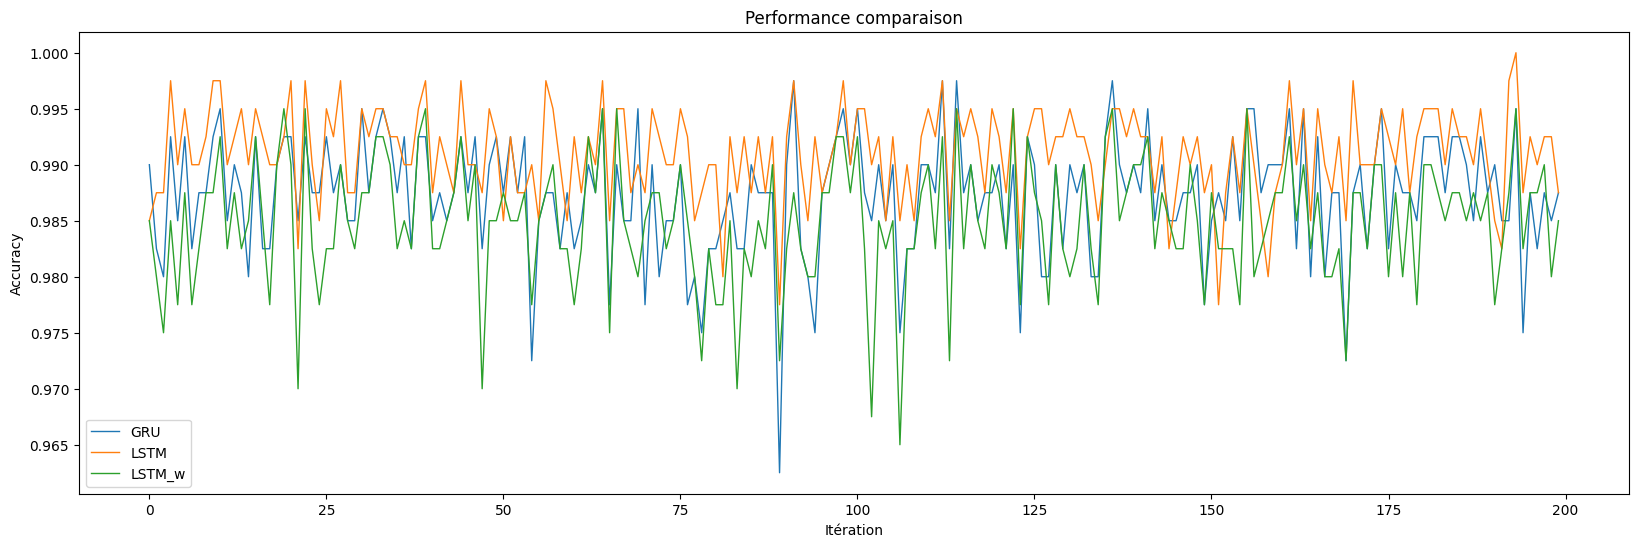

In [53]:
plt.figure(figsize=(20, 6))
plt.plot(acc_gru, label="GRU", linewidth=1)
plt.plot(acc_lstm, label="LSTM", linewidth=1)
plt.plot(acc_lstm_w, label="LSTM_w", linewidth=1)
plt.xlabel("Itération")
plt.ylabel("Accuracy")
plt.title("Performance comparaison")
plt.legend()
plt.show()

## Results Random Forest

##### For 50 same file (test2)

In [18]:
np.mean(acc_gru), np.mean(acc_lstm), np.median(acc_gru), np.median(acc_lstm)

(0.98645, 0.9913620000000001, 0.9873000000000001, 0.9915)

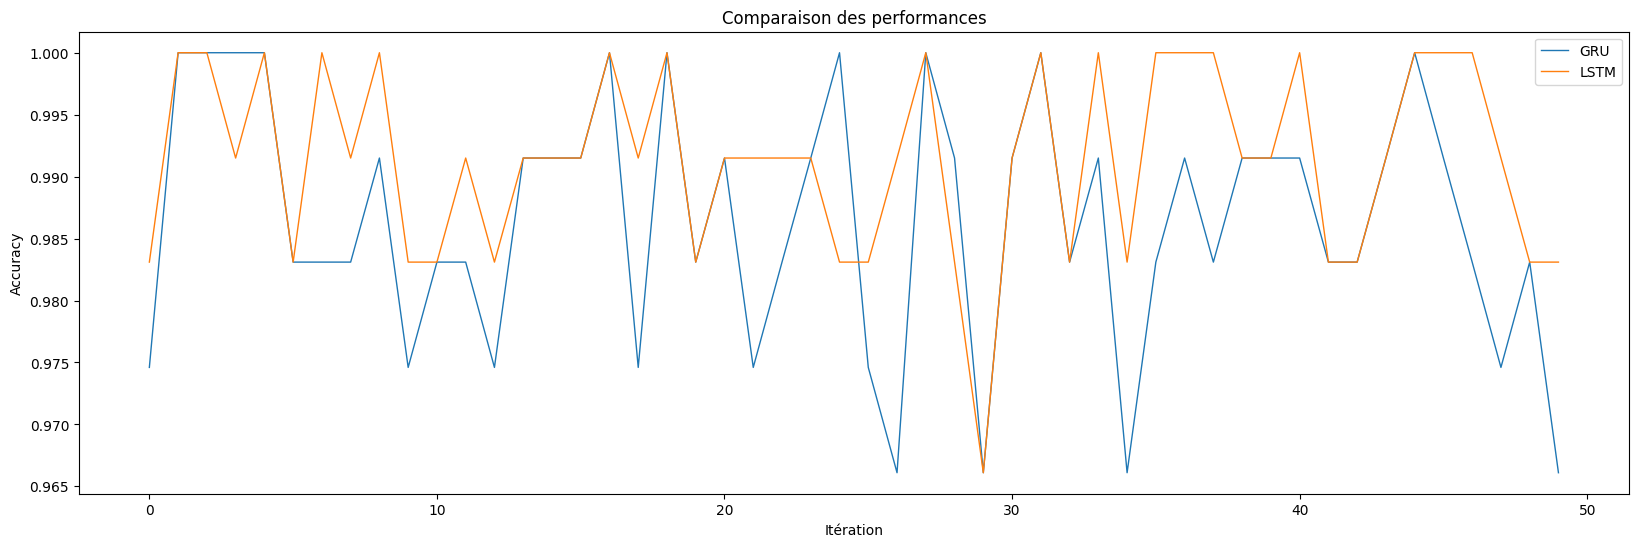

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(acc_gru, label="GRU",linewidth=1)
plt.plot(acc_lstm, label="LSTM",linewidth=1)
plt.xlabel("Itération")
plt.ylabel("Accuracy")
plt.title("Performance comparaison")
plt.legend()
plt.show()

##### For 1000 same file (test2)

In [138]:
np.mean(acc_gru), np.mean(acc_lstm), np.median(acc_gru), np.median(acc_lstm)

(0.9861336000000002, 0.9899324000000002, 0.9915, 0.9915)

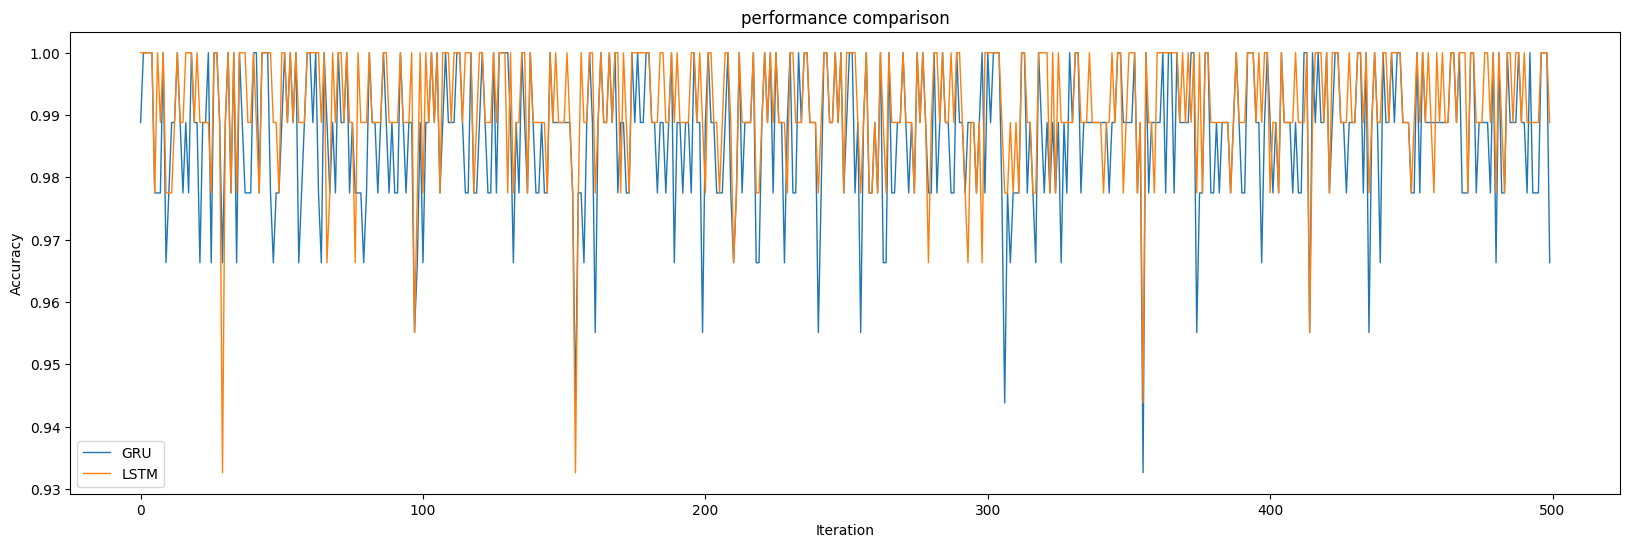

In [135]:
plt.figure(figsize=(20, 6))
plt.plot(acc_gru, label="GRU",linewidth=1)
plt.plot(acc_lstm, label="LSTM",linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Performance comparaison")
plt.legend()
plt.show()